# Pathogens

Here we present the develped assessment hierarchy for a decision aid that enables the exploratory analysis and deliberation of actions on emerging chemical drinking water contaminants with a limited evidence base. This analysis is based on MAVT, and it is implemented around the Decisi-o-rama package.


In [15]:
# We import the required libraries
import glob
from os.path import join, sep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from decisiorama.pda.preference import Objective, utility, aggregate
from decisiorama.utils import random_instance as ri
from decisiorama.utils import alternative_builder as ab

# Change this to anything that suits
plt.style.use('fivethirtyeight')

## Problem definition

Here we define the different aspects of the MAVT model, and in the end the model is assembled, run, and its results are visualised. The components are defined as:

1. [Number of random samples](#Random-Samples)
2. [List of objectives in the hierarchy](#Objectives)
3. [Direction of attributes](#Direction)
4. [Bounds at the attribute level](#Bounds)
5. [Defining objectives hierarchy](#Children)
6. [Defining the value functions for each objective](#Value-Functions)
7. [Defining the weights for each objective](#Weights)
8. [Defining the aggregation function to be used in each objective](#Aggregation-Functions)
9. [Defining the value of the alternatives in the attributes](#Alternatives)

Once the definintions have been provided we build and evaluate the model by:

10. [Creating and running the objectives and its hierarchy](#Building)
11. [Visualising the results](#Visualisation)

<a id="Random-Samples"></a>
### Random samples

We define the number of random samples for the Monte carlo simulation (`n`)

In [16]:
n = 10000

<a id="Objectives"></a>
### Objectives

We list the objectives that are part of the hierarchy. The order of this list is not relevant.

In [17]:
name= ['Score',
       'Presence_surf_water',
       'Beh_WWTP',
       'Per_surf_water',
       'coa_rf',
       'ac',
       'uv_dis',
       'Beh_DWTP', 
       'Poll_DS', 
       'Pot_exp_DDW', 
       'p_death',
       'sequelae',
       'discomfort',
       'Pot_sev_health',
       'imp_exposure',
       'sec_spread',
       ]  

<a id="Direction"></a>

### Direction
Define the side of the value function. If `True`, indicates that the maximum value is achieved when the indicator is maximised. Otherwise, it is assume that the value of the indicator is maximum, when its in natural scale is Minimum.

In [18]:
ifmax = {'Score': True,
         'Presence_surf_water': True,
         'Beh_WWTP': False,
         'Per_surf_water': True,
         'coa_rf': False,
         'ac': False,
         'uv_dis': False,
         'Beh_DWTP': False,
         'Poll_DS': True,
         'Pot_exp_DDW': True,
         'p_death': True,
         'sequelae': True,
         'discomfort': True,
         'Pot_sev_health': True,
         'imp_exposure': True,
         'sec_spread': True,
        }

<a id="Bounds"></a>
### Bounds

The bounds establish what are the limits for the different objectives in the hierarchy. Values over the interval are automatically set to its maximum, while below the minimum will be set to this value.

In [19]:
bounds = {'Score': [0.0, 1.0],
          'Presence_surf_water': [0, 3],
          'Beh_WWTP': [0, 19],
          'Per_surf_water': [0, 100],
          'coa_rf': [0, 1],
          'ac': [0, 19],
          'uv_dis': [0, 19],
          'Beh_DWTP': [0, 19],
          'Poll_DS': [0, 365],
          'Pot_exp_DDW': [0, 1],
          'p_death': [0, 1],
          'sequelae': [0, 1],
          'discomfort': [0, 1],
          'Pot_sev_health': [0, 1],
          'imp_exposure': [0, 100],
          'sec_spread': [0, 1],
         }

<a id="Children"></a>
### Hierarchical structure

Here we define the hierarchy on the objectives by defining the children of each objective. If an objective does not have a children, it is used an empty list (`[]`).

In [20]:
children = {'Score': ['Pot_exp_DDW', 'Pot_sev_health', 
                      'imp_exposure', 'sec_spread'],
            'Presence_surf_water': [],
            'Beh_WWTP': [],
            'Per_surf_water': [],
            'coa_rf': [],
            'ac': [],
            'uv_dis': [],
            'Beh_DWTP': ['coa_rf', 'ac', 'uv_dis'],
            'Poll_DS': [],
            'Pot_exp_DDW': ['Presence_surf_water', 'Beh_WWTP', 
                            'Per_surf_water', 'Beh_DWTP', 'Poll_DS'],
            'p_death': [],
            'sequelae': [],
            'discomfort': [],
            'Pot_sev_health': ['p_death', 'sequelae', 'discomfort'],
            'imp_exposure': [],
            'sec_spread': []
            }

<a id="Value-Functions"></a>

### Value Functions

At this point we define custom value functions that are used in the analysis. Notice that the return of these functions, are functions as well.

In [21]:
def valuefun_tabular(x, y):
    '''value function constructor'''
    if np.max(y) > 1.0:
        raise ValueError('value in table higher than 1')
    
    def _t(xx, *args, **kwargs):
        xx = xx*np.max(x)
        return np.clip(np.interp(xx, x, y), 0, 1)    
    return _t

Here we assign the value function to each of the objectives. In this context, a linear value function is represented by a `utility.exponential` function with a curvature (`r`) equal to 0. Also, notice that we are assigning functions and not results

In [22]:
util_funcs = {'Score': utility.exponential,
              'Presence_surf_water': utility.exponential,
              'Beh_WWTP': utility.exponential,
              'Per_surf_water': utility.exponential,
              'coa_rf': utility.exponential,
              'ac': utility.exponential,
              'uv_dis': utility.exponential,
              'Beh_DWTP': utility.exponential,
              'Poll_DS': valuefun_tabular(
                  x = [0.0, 7.00/365.0, 32.0/365.0, 1.0], 
                  y = [0.0, 0.33, 0.67, 1.00]),
              'Pot_exp_DDW': utility.exponential,
              'p_death': utility.exponential,
              'sequelae': utility.exponential,
              'discomfort': utility.exponential,
              'Pot_sev_health': utility.exponential,
              'imp_exposure': utility.exponential,
              'sec_spread': utility.exponential,
              }

<a id="Weights"></a>

### Weights

Here we define the weights for each of the nodes in the hierarchy. Weights are linearly normalised by Decisiorama when processing the results.

In [23]:
weights = {'Score' : 1.0, 
           'Presence_surf_water' : 1.0,
           'Beh_WWTP' : 1.0,
           'Per_surf_water' : 1.0,
           'coa_rf' : 1.0,
           'ac' : 1.0,
           'uv_dis' : 1.0, 
           'Beh_DWTP' : 1.0,
           'Poll_DS' : 1.0,
           'Pot_exp_DDW' : 1.0,
           'p_death' : 1.0,
           'sec_spread' : 1.0,
           'sequelae' : 1.0,
           'discomfort' : 1.0, 
           'Pot_sev_health' : 1.0,
           'imp_exposure' : 1.0,
           'sec_spread' : 1.0,
           }

<a id="Aggregation-Functions"></a>

### Aggregation Functions

In this point what type of aggregation we are selecting for each of the nodes. If the node is an attribute node, the selection of the aggregation function is irrelevant.

In [24]:
aggregation_functions = {'Score' : aggregate.additive,
                         'Presence_surf_water' : aggregate.additive,
                         'Beh_WWTP' : aggregate.additive,
                         'Per_surf_water' : aggregate.additive,
                         'coa_rf' : aggregate.additive, 
                         'ac' : aggregate.additive,
                         'uv_dis' : aggregate.additive,
                         'Beh_DWTP' : aggregate.additive, 
                         'Poll_DS' : aggregate.additive, 
                         'Pot_exp_DDW' : aggregate.additive, 
                         'p_death' : aggregate.additive, 
                         'sequelae' : aggregate.additive,
                         'discomfort' : aggregate.additive, 
                         'Pot_sev_health' : aggregate.additive,
                         'imp_exposure' : aggregate.additive,
                         'sec_spread' : aggregate.additive,
                          }    

<a id="Alternatives"></a>

### Alternatives

Here we read the alternatives from plain files (`*.attr` files) used to parametrise the model. In this particular case, we are reading the alternatives located in the `alternatives/pathogens` folder.

In [25]:
# Read and parse alternatives from files
fnames = glob.glob(join('alternatives','pathogens','*.attr'))
alternatives = {name.split(sep)[-1][:-5] : ab.reader(name) for name in fnames}

<a id="Building"></a>

### Building objectives hierarchy

With the previously defined elements, we proceed to build the objectives hierarchy, and obtain the results for each of the elements. The final objective is to determine the `'Score'` For each of the individual alternatives.

In [26]:
# build the hierarchy tree

_d_alt = list(alternatives.keys())[0]

vals = {}
for alt in alternatives:
    objs = {}
    for name_i in name:
        if name_i in alternatives[_d_alt].keys():
            _alt_value = alternatives[alt][name_i]  # Taken from the alternatives file
        else:
            _alt_value = None  # calculated as the aggregation of alternatives
    
        
        # Build the objectives
        objs[name_i] = Objective(name = name_i, 
                                 w = weights[name_i],
                                 alternatives = [_alt_value,],
                                 obj_min = bounds[name_i][0], 
                                 obj_max = bounds[name_i][1], 
                                 n = n,
                                 utility_func = util_funcs[name_i], 
                                 utility_pars = [0.0, ],
                                 aggregation_func = aggregation_functions[name_i],
                                 aggregation_pars = ri.Uniform(0.5, 0.5).get,
                                 maximise = ifmax[name_i]
                                 )
    
    # Build the hierarchy (assign children to parent objectives)
    for name_i in objs:
        if children[name_i] != []:
            [objs[name_i].add_children(objs[child_i]) for child_i in children[name_i]]        
    vals[alt] = objs['Score'].get_value([1.0,])

res = pd.DataFrame(vals)

<a id="Visualisation"></a>

### Visualisation

Finally, we proceed to the visualisation of the results. To this end, we use a boxplot to inspect the results of the analysis.

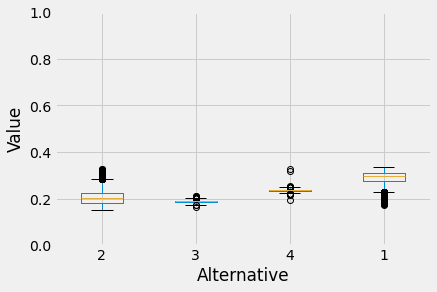

In [27]:
plt.figure()
res.boxplot()
plt.ylim([0, 1])
plt.ylabel('Value')
plt.xlabel('Alternative')
plt.show()